# 0.0 Imports


In [137]:
import math
import inflection
import seaborn    as sns
import numpy      as np
import pandas     as pd


from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats     as ss
from matplotlib            import pyplot    as plt
from ipykernel             import kernelapp as app
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# 0.1 Helper Functions

In [138]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [139]:
 jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 0.2 Loading Data

In [140]:
# low_memory=False -> ler o arquivo de uma vez para a memóris
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 Data Description

In [141]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [142]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore (x)
cols_news = list(map( snakecase, cols_old))

#rename
df1.columns = cols_news

## 1.2 Data Dimensions

In [143]:
print( 'Number od Rowns: {}'.format(df1.shape[0]))
print( 'Number od Columns: {}'.format(df1.shape[1]))

Number od Rowns: 1017209
Number od Columns: 18


## 1.3 Data Types

In [144]:
df1['date'] = pd.to_datetime( df1['date'])

## 1.4 Check NA

In [145]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [146]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6 Change Types

In [147]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## 1.7 Descriptive Statistical

In [148]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [149]:
# Central Tendency - mean, median
t1 = pd.DataFrame (num_attributes.apply(np.mean)).T
t2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skwe, kutosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(np.min)).T
d3 = pd.DataFrame (num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
m1 = pd.concat([d2, d3, d4, t1, t2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


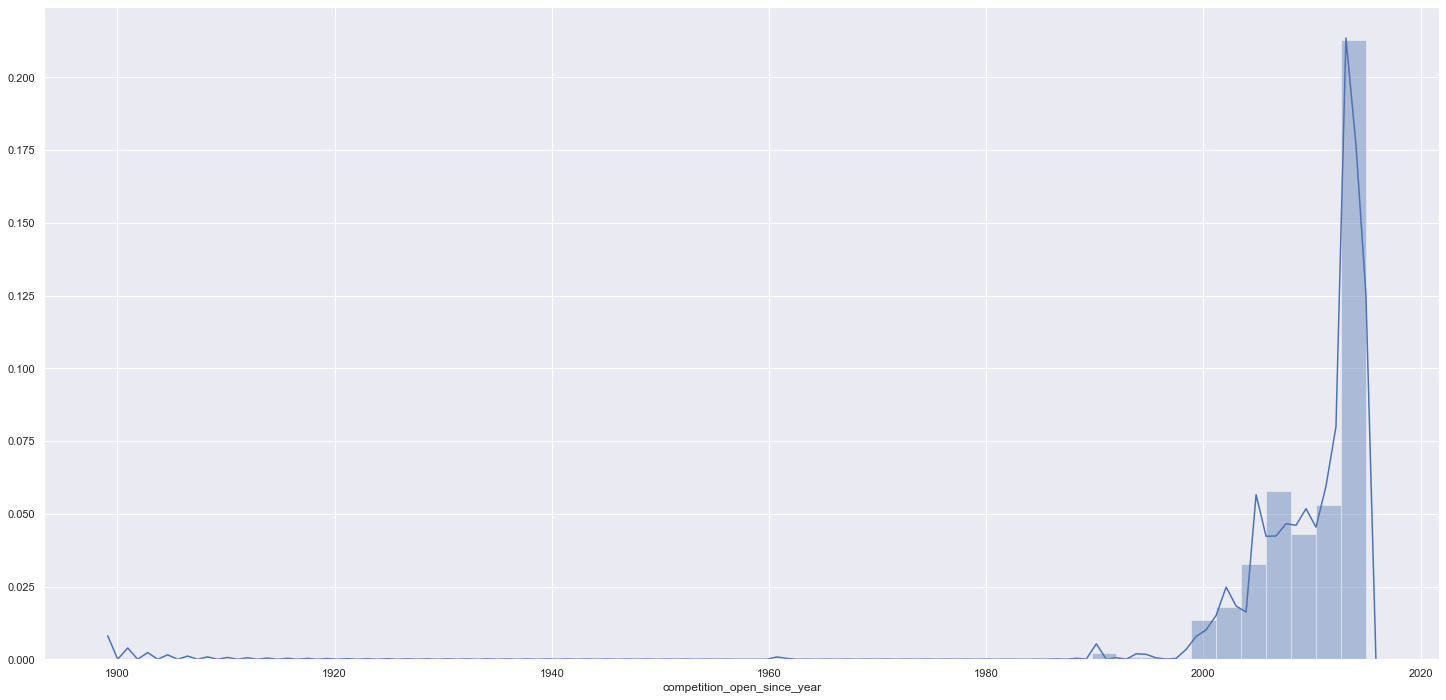

In [150]:
sns.distplot(df1['competition_open_since_year'])

### 1.7.1 Categorical Attributes

In [151]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

# 2.0 Feature Engineering

In [152]:
df2 = df1.copy()

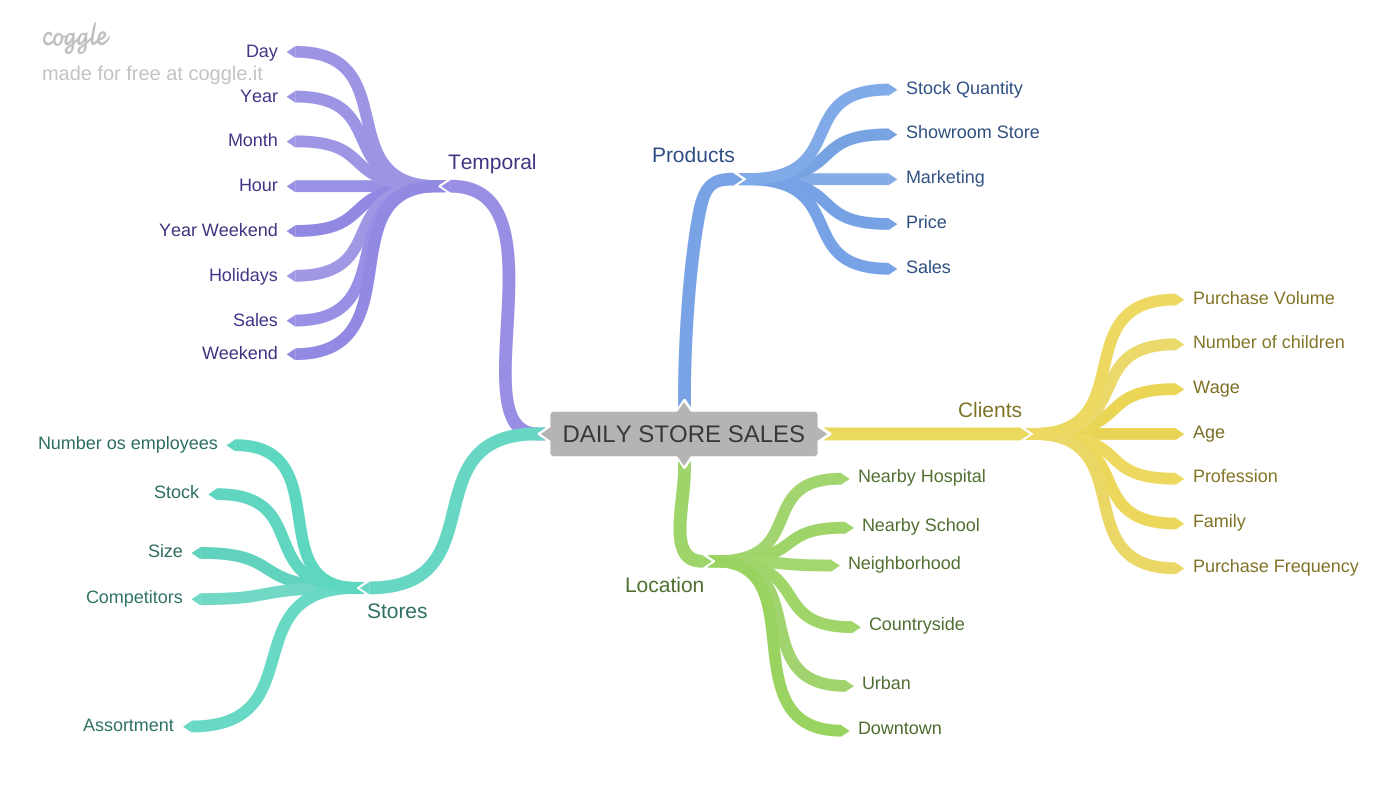

In [153]:
Image('img/Mindmap.png')


## 2.1 Mindmap Hipothesis

### 2.1.1 Store Hipothesis

**1.** Stores with greater staff should sell more.

**2.** Stores with greater stock should sell more.

**3.** Lager stores should sell more.

**4.** Smaller should sell less.

**5.** Stores with greater assortment should sell more.

**6.** Stores with close competitors should sell less.

### 2.1.2 Product Hipothesis

**1.** Stores with signficant investment in Marketing should sell more.

**2.** Stores with a greater number of products in showcase should sell more.

**3.** Stores with reduced prices should sell more.

**4.** Stores with reduced prices for a long time should sell more.

### 2.1.3 Time Hipothesis

**1.** During Chirstmas stores should sell more.

**2.** Over the years stores should sell more.

**3.** During school holidays stores should sell less.

**4.** After second week of each month stores shoud sell more.

**5.** During weekends stores should sell less.


## 2.2 Final Hypothesis list

**1.** Stores with greater assortment should sell more.

**2.** Stores with close competitors should sell less.

**3.** Stores with a longer time competitors should sell more.

**4.** Stores with reduced prices for a long time should sell more.

**5.** Stores with extended days sales should sell more.

**6.** Stores with consecutive sales should sell more.

**7.** During Chirstmas holiday, stores should sell more.

**8.** Over the years stores should sell more.

**9.** During the second semester, stores should sell more.

**10.** After day 10 of each month stores shoud sell more.

**11.** During weekends ,stores should sell less.

**12.** During school holidays, stores should sell less.

## 2.3 Feature Engineering

In [154]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int ) 

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# Promo since is a str now. The next step is convert to date. Apply only in promo_since column 
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
# result in weeks (/7) and extract days (x.days)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype( int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x == 'c' else 'regular_day')


# 3.0  Filtering

In [155]:
df3 = df2.copy()

## 3.1 Row Filtering

In [156]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [157]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


# 4.0 Data Mining

In [158]:
 df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

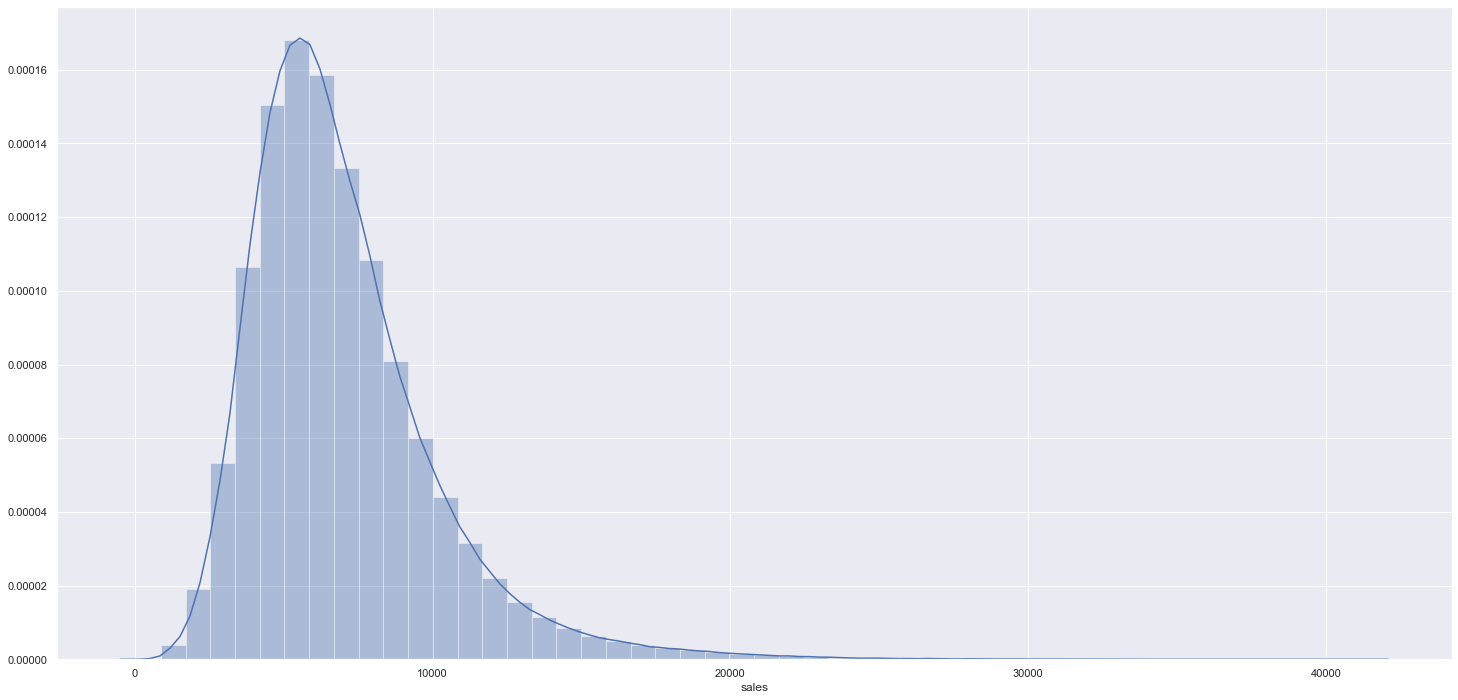

In [159]:
sns.distplot( df4['sales'] )

### 4.1.2 Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2c5e97c50>,
      dtype=object)

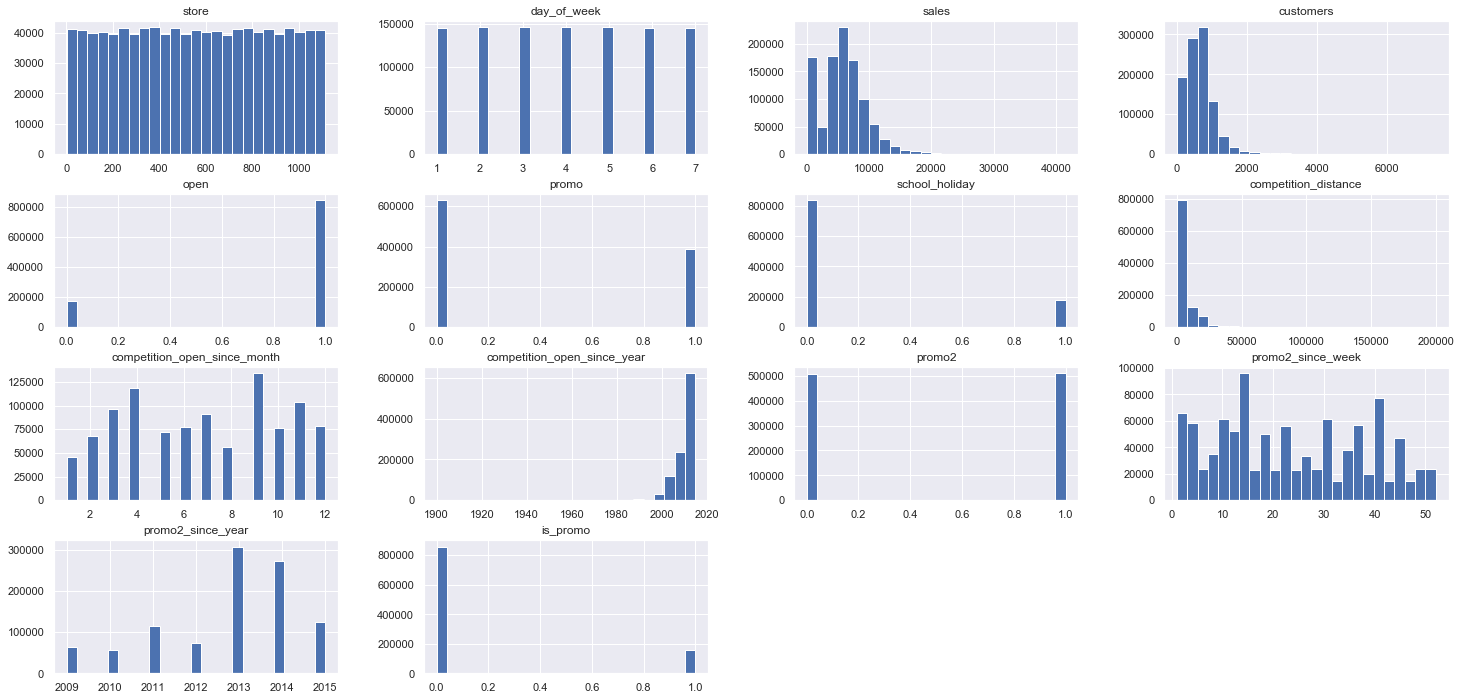

In [160]:
num_attributes.hist(bins=25)

### 4.1.3 Categorical Variable

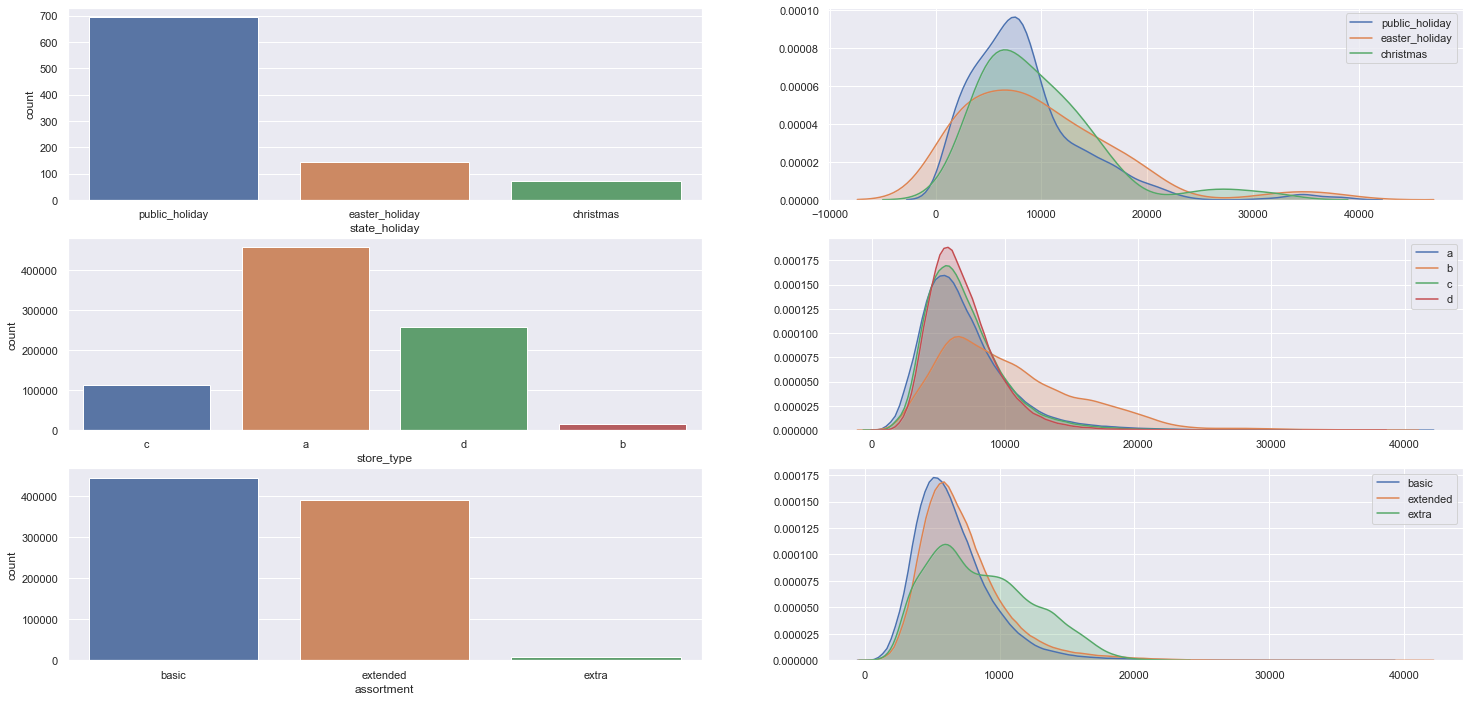

In [161]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )



### 4.2 Bivariate Analysis

**H1.** Stores with greater assortment should sell more.

**H1. Validation = False:** Stores with greater assortment **sell less.**

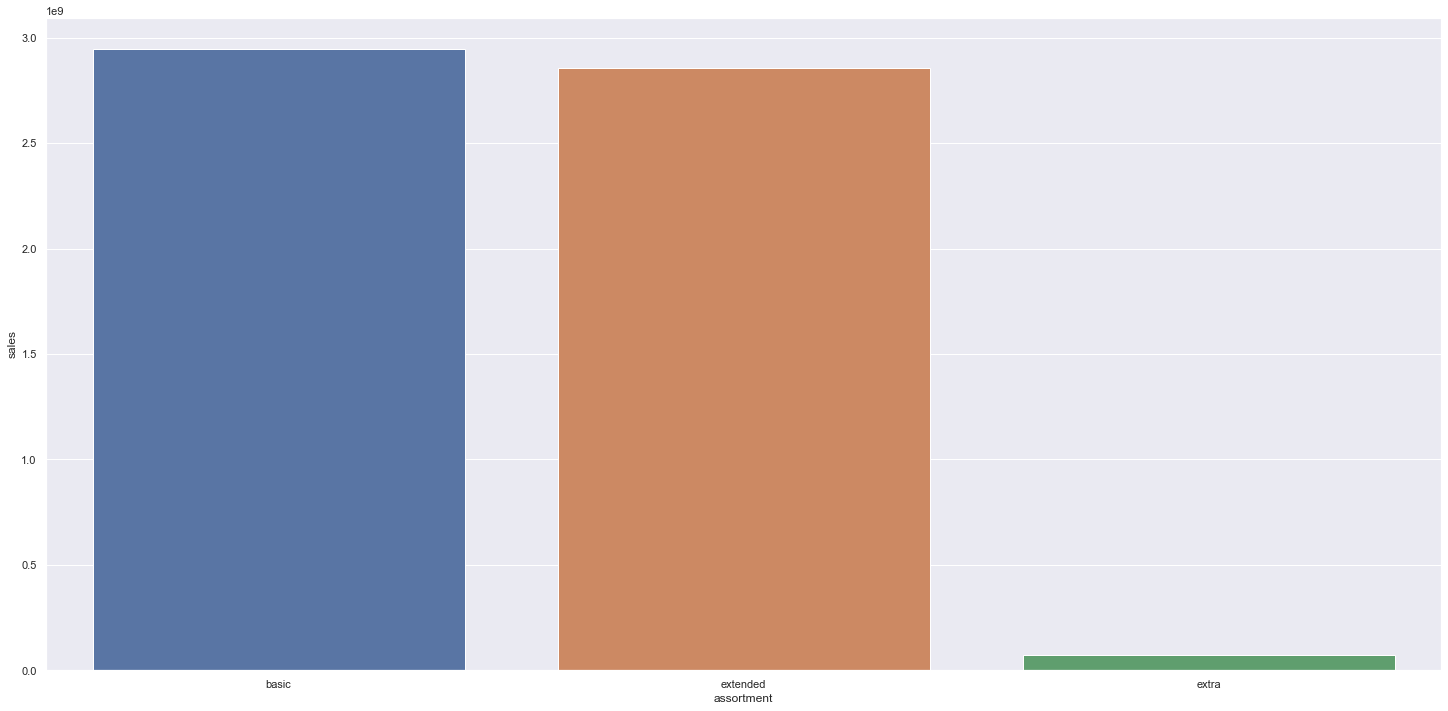

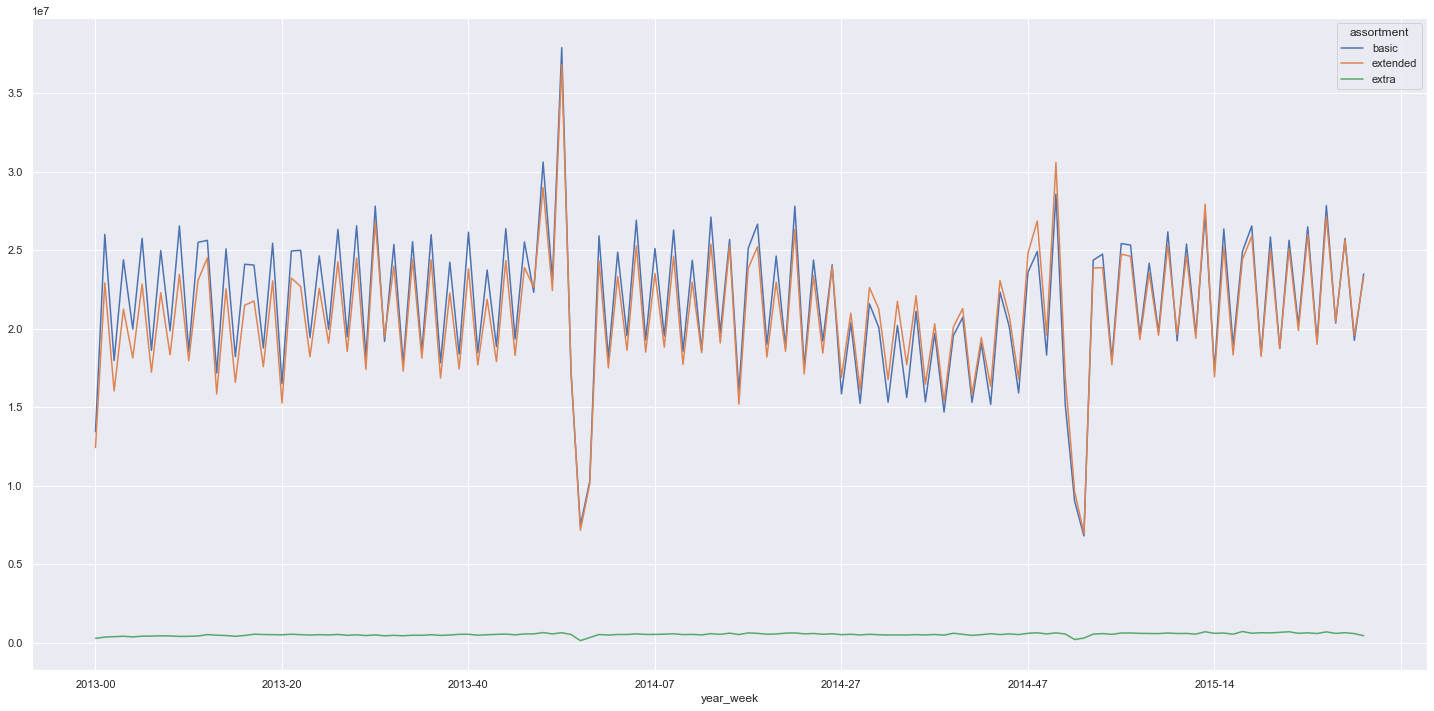

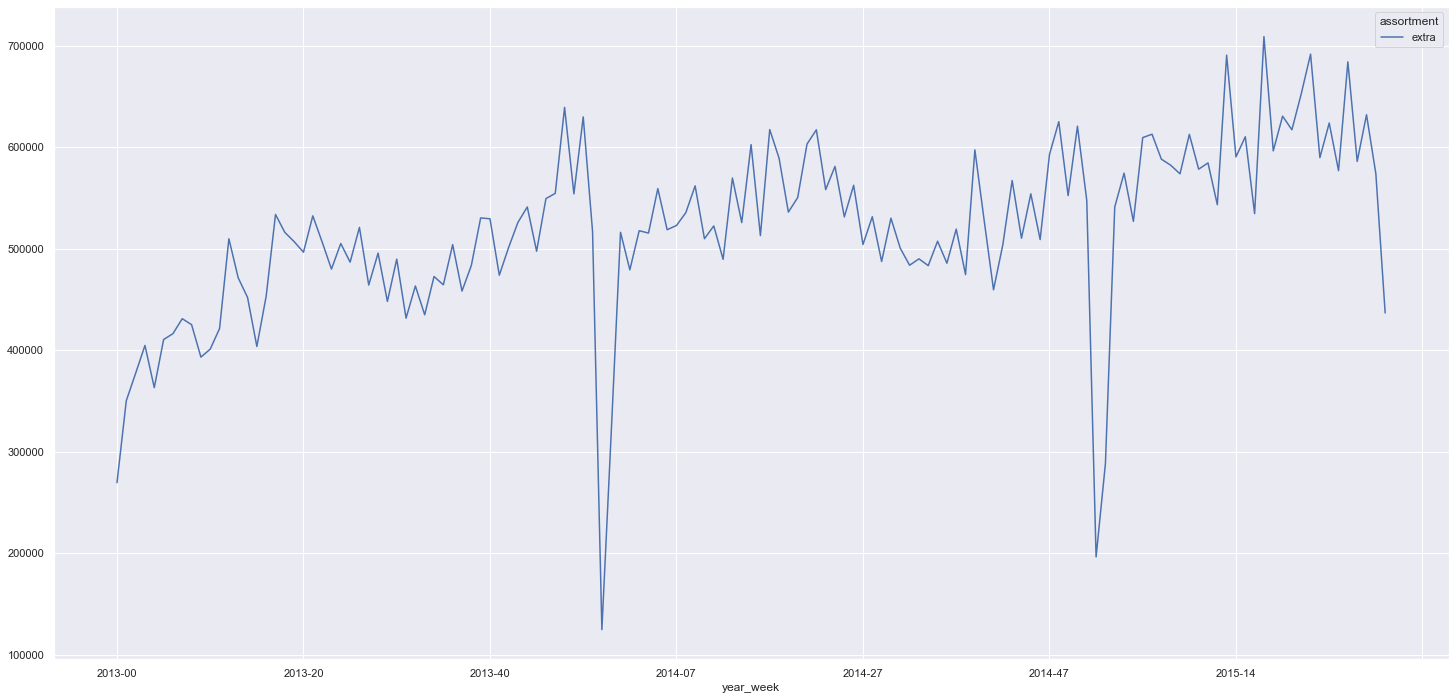

In [162]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

# basically 'basic' and 'extended' have same trend.
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot();

# 'assortment' trend
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot();

**H2.** Stores with close competitors should sell less.

**H2. Validation = False:** Stores with close competitors **sell more.**

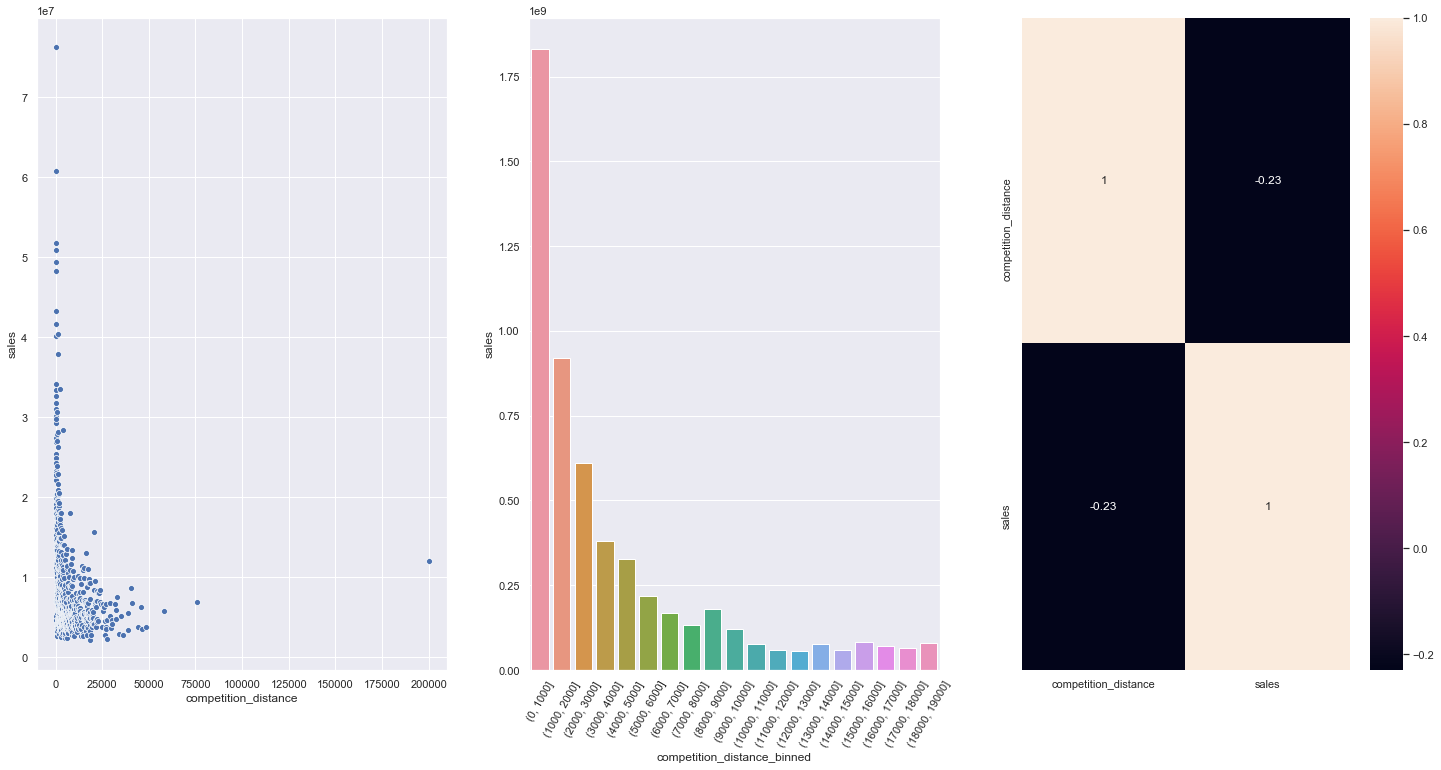

In [163]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1 )
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks (rotation=60)

# correlation('competition_distance', 'sales')
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot = True)



**H3.** Stores with a longer time competitors should sell more.

**H3. Validation = False:** Stores with a longer time competitors **sell less.**

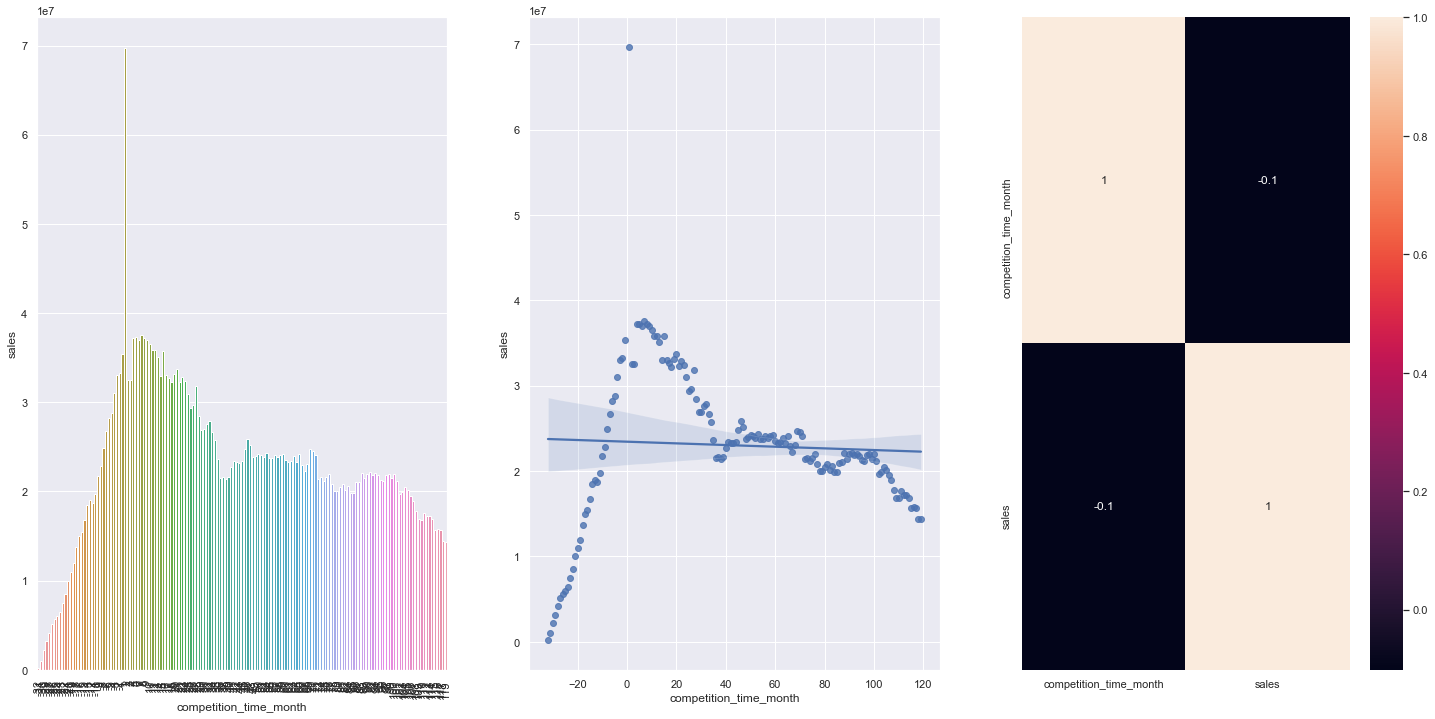

In [164]:
# When values come closer to zero, greater is the amount of sales
plt.subplot(1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks (rotation=90);

plt.subplot(1, 3, 2 )
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3 )
x = sns.heatmap(aux1.corr(method='pearson'), annot = True)

**H4.** Stores with reduced prices for a long time should sell more.

**H4. Validation = False:** Stores with reduced prices for a long time **sell less,** after a time period.

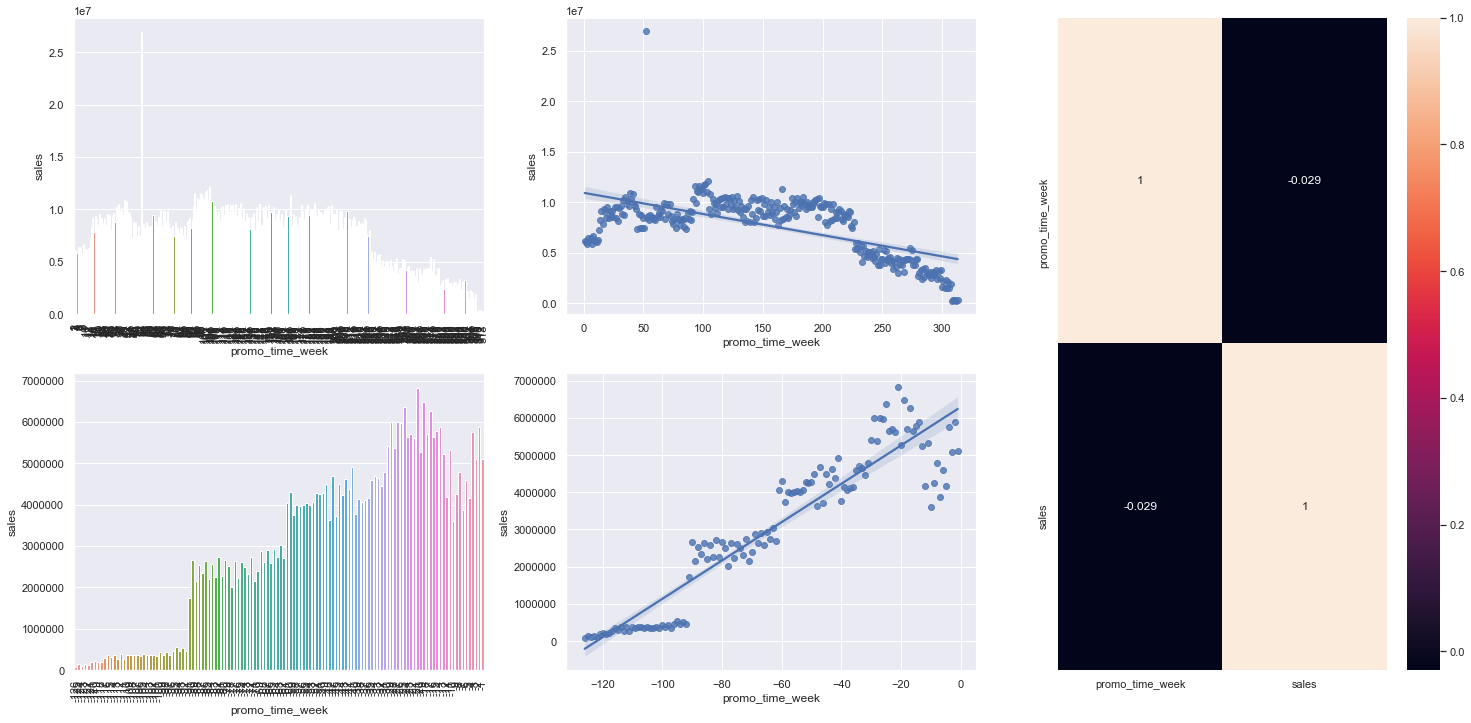

In [165]:
# when 'promo' ended up, 'promo_2' has started.
# if promo_time_week is positive, it is related with 'promo_2' (extended)
# If promo_time_week is negative, it is related with  'promo' (regular promo)
#plt.subplot(1, 3, 1 )
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week'] > 0 ] # extend promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3=aux1[aux1['promo_time_week'] < 0 ] # regular promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

# Insight: When store inform about promo, occurs the sale increasement. But extended promo has a time period.

# correlation --> Is not a relevant feature.
plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method = 'pearson'), annot=True);



### <s>**H5.** Stores with extended days sales should sell more. This hypothesis will be validated in the next CRISP.<s>

**H6.** Stores with consecutive sales should sell more.

**H6. Validation = False:** Stores with consecutive sales  **sell less.**

In [166]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


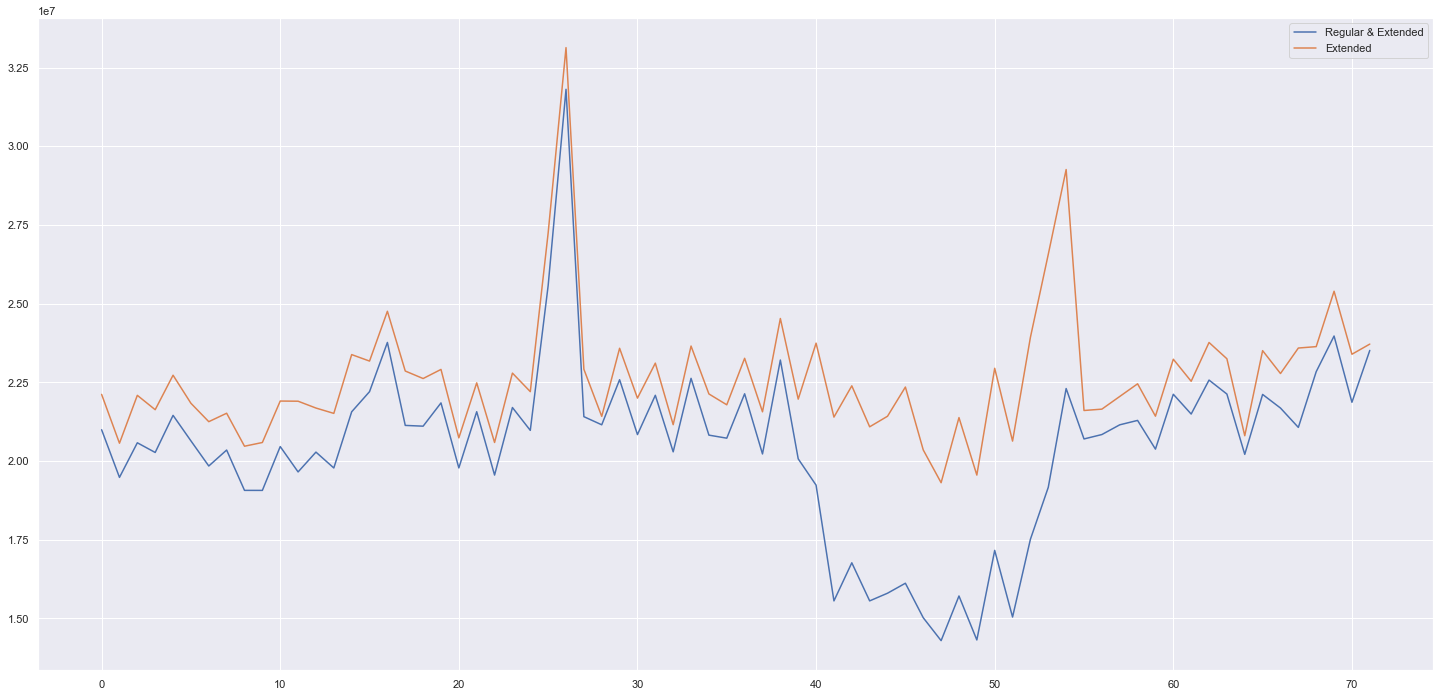

In [167]:
# Stores that joined a regular promo and extended promo
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()         

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)  

ax.legend( labels=['Regular & Extended', 'Extended']);

**H7.** During Chirstmas, stores should sell more.



**H7. Validation = False:** During Chirstmas holiday, stores **sell less.**

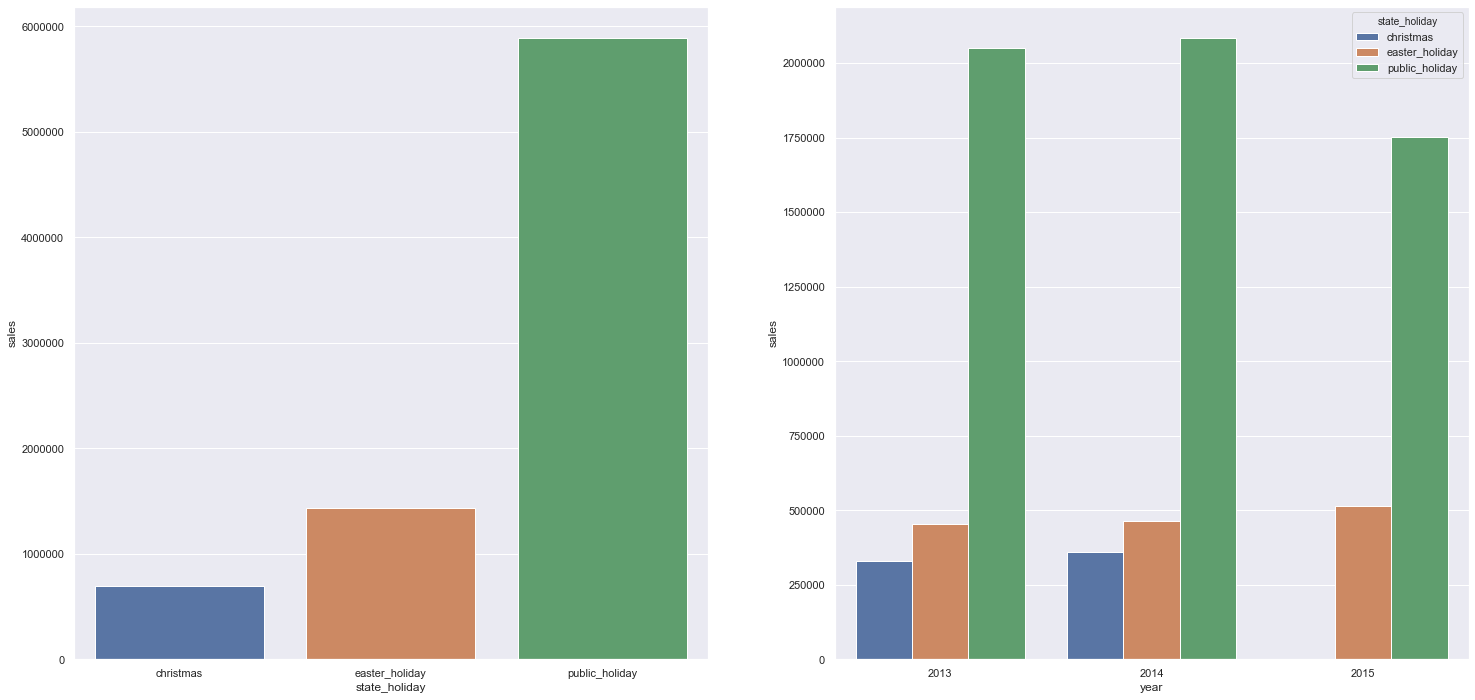

In [168]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 )

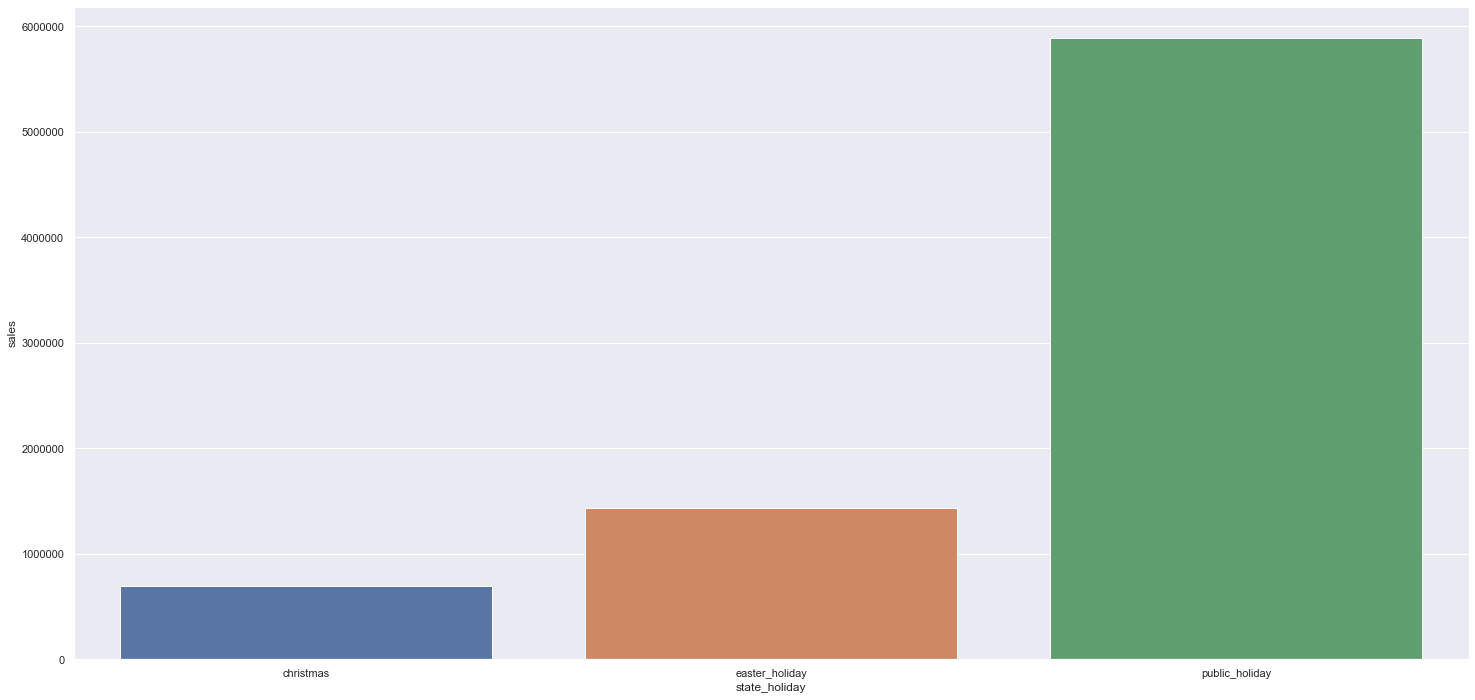

In [169]:

sns.barplot( x = 'state_holiday', y = 'sales', data = aux1);



**H8.** Over the years stores should sell more.

**H8. Validation = False:** Over the years stores **sell less.**

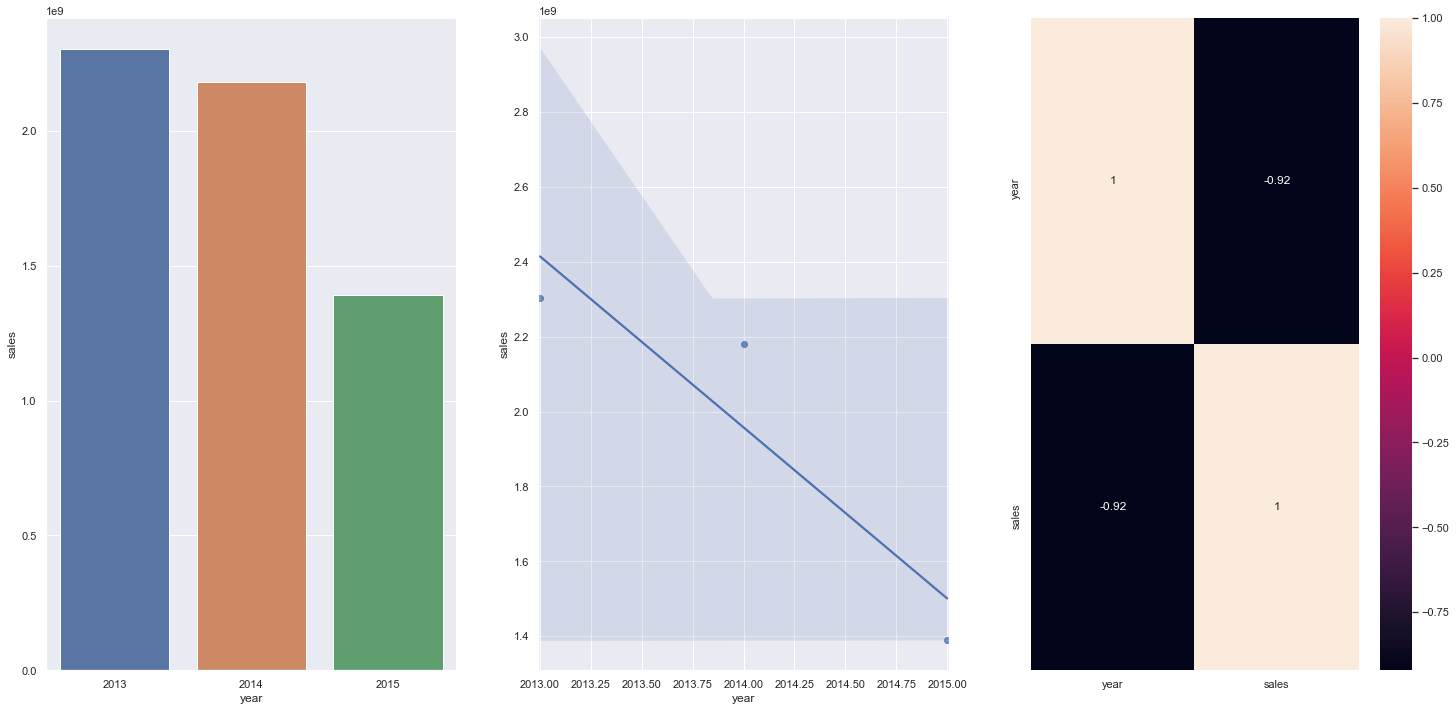

In [170]:
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'year', y = 'sales', data = aux1);

# strong negative correlation. Over the years, sales fall.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H9.** During the second semester, stores should sell more.

**H9. Validation = False:** During the second semester, stores  **sell less.**

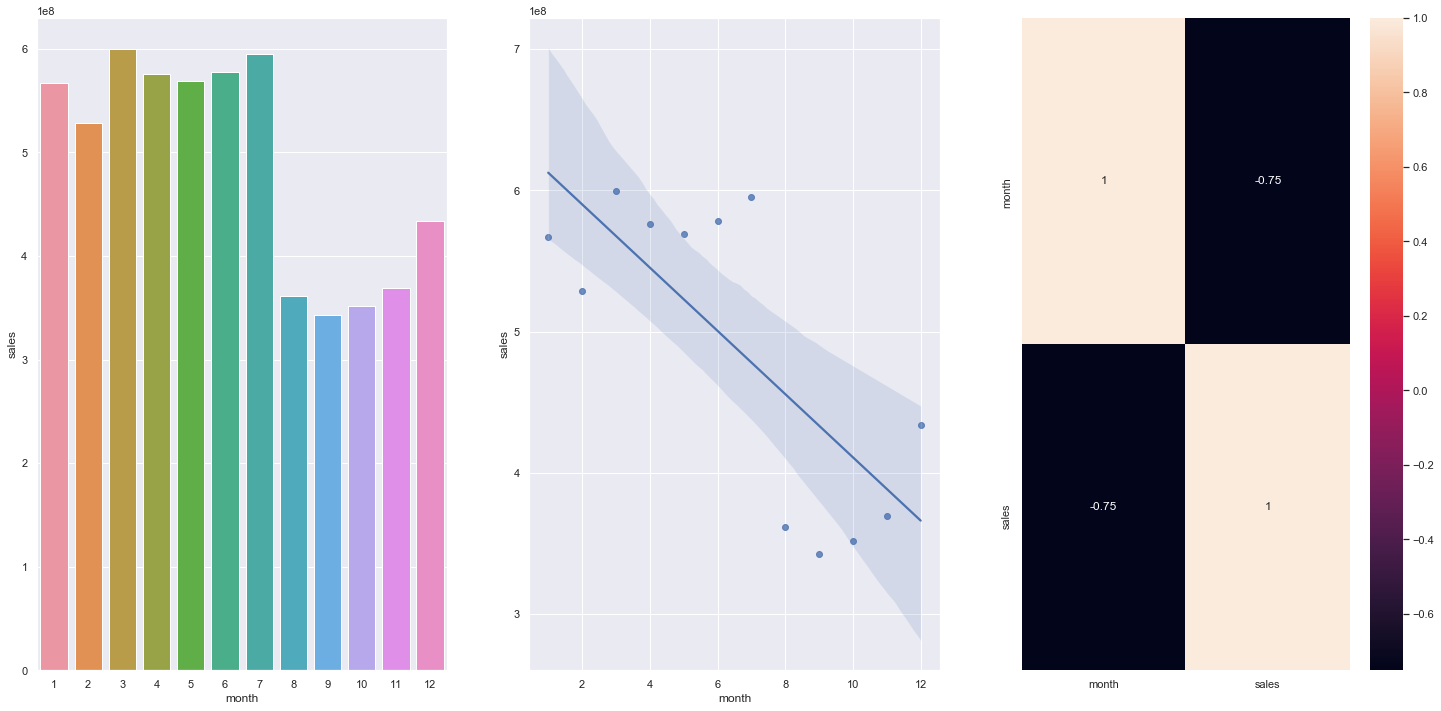

In [171]:
# H9 is an important feature.
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'month', y = 'sales', data = aux1);

# strong negative correlation. Over the years, sales fall.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);




**H10.** After day 10 of each month, stores shoud sell more.

**H10.** Validation = True: After day 10 of each month, stores **sell more.**

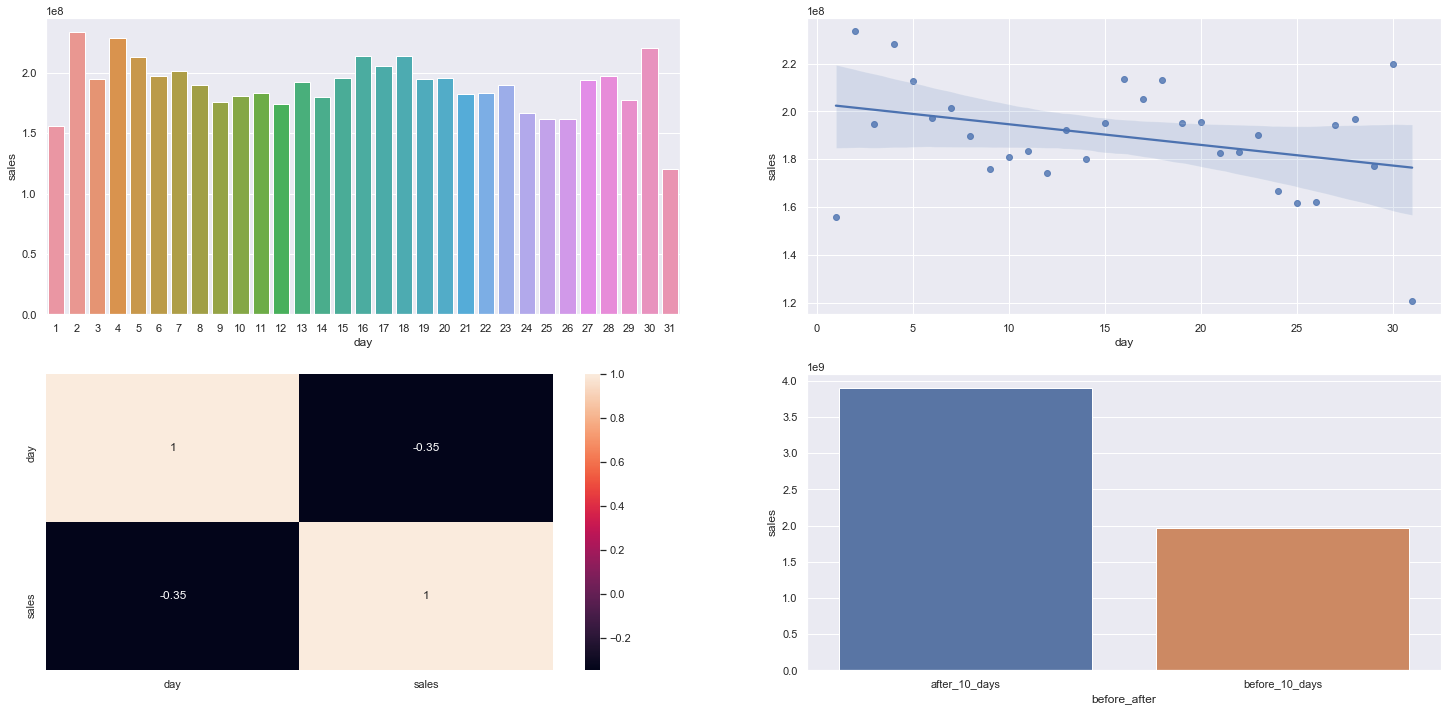

In [172]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot( x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot( x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);


**H11.** During weekends ,stores should sell less.

**H11.** Validation = True: During weekends, stores **sell less.**

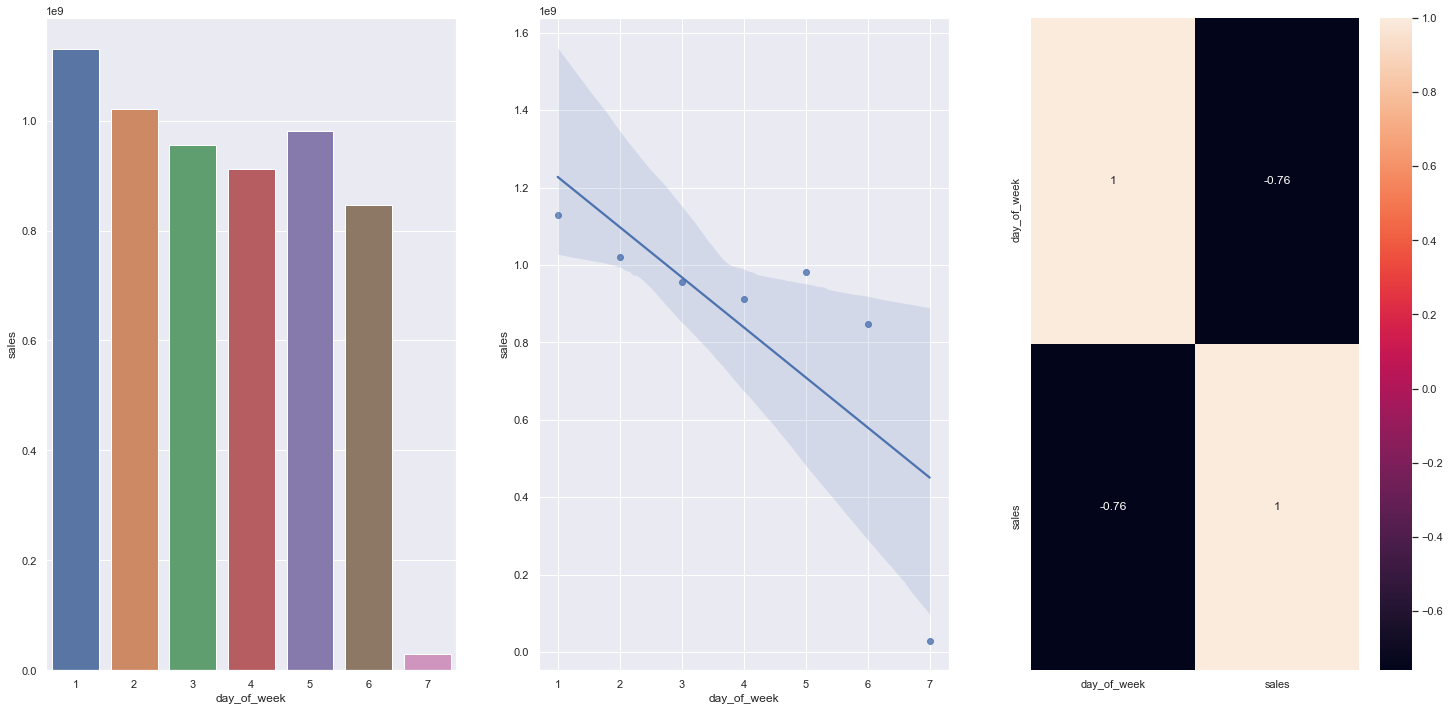

In [173]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1);

# Strong negative correlation.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

**H12.** During school holidays, stores should sell less.

**H12. Validation = True:** During school holidays, stores **sell less.** Except in July an August, because sales are similar between regular day and school holiday.

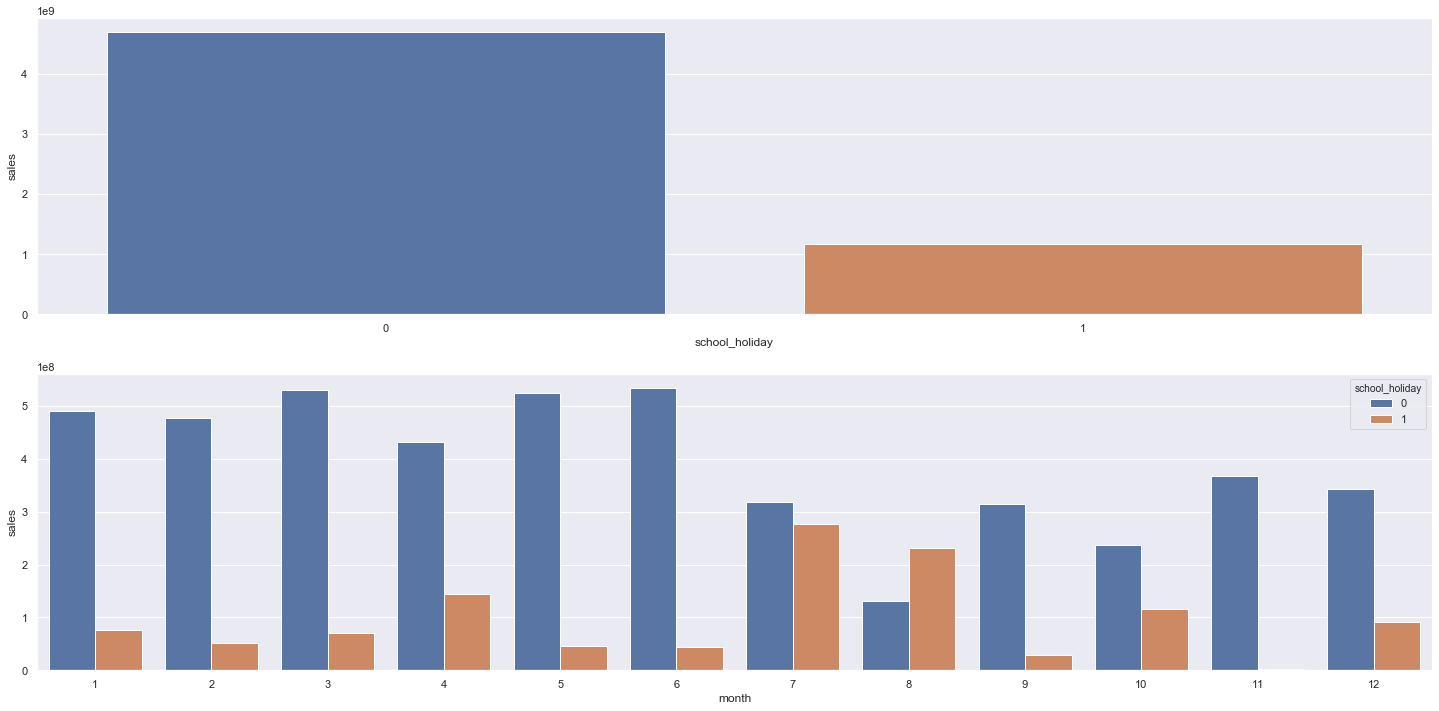

In [174]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

#### 4.2.1 Summary oh Hypothesis

In [175]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Medium'],
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Medium'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low']
      ]
print( tabulate( tab, headers = 'firstrow'))
    

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

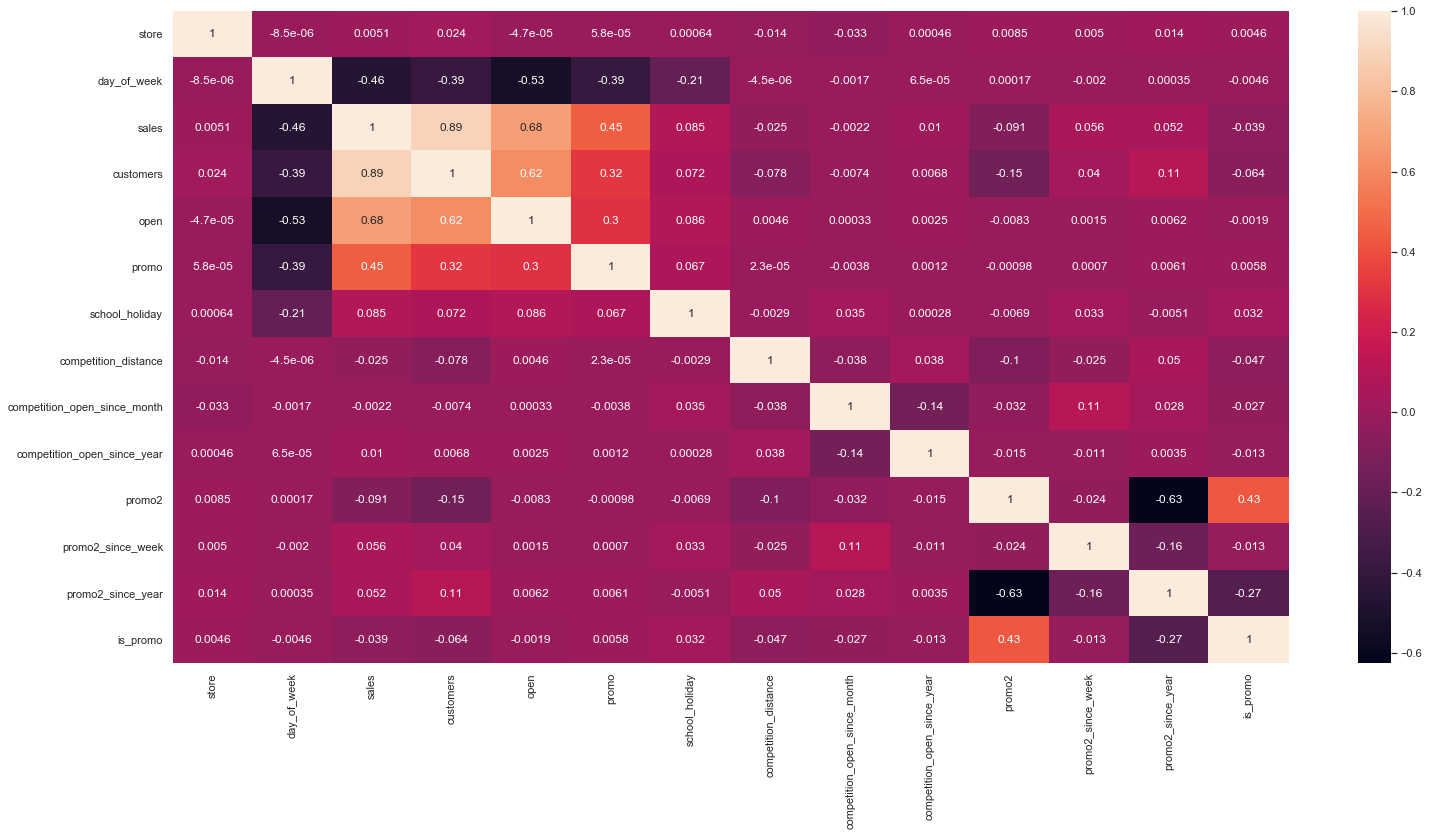

In [176]:
correlation = num_attributes.corr( method = 'pearson')
sns.heatmap(correlation, annot = True);

# 5.0 Data Preparation

In [177]:
df5 = df4.copy()

## 5.1 Data Normalizantion

## 5.2 Rescaling

In [178]:
a = df5.select_dtypes ( include = ['int64', 'float64'])

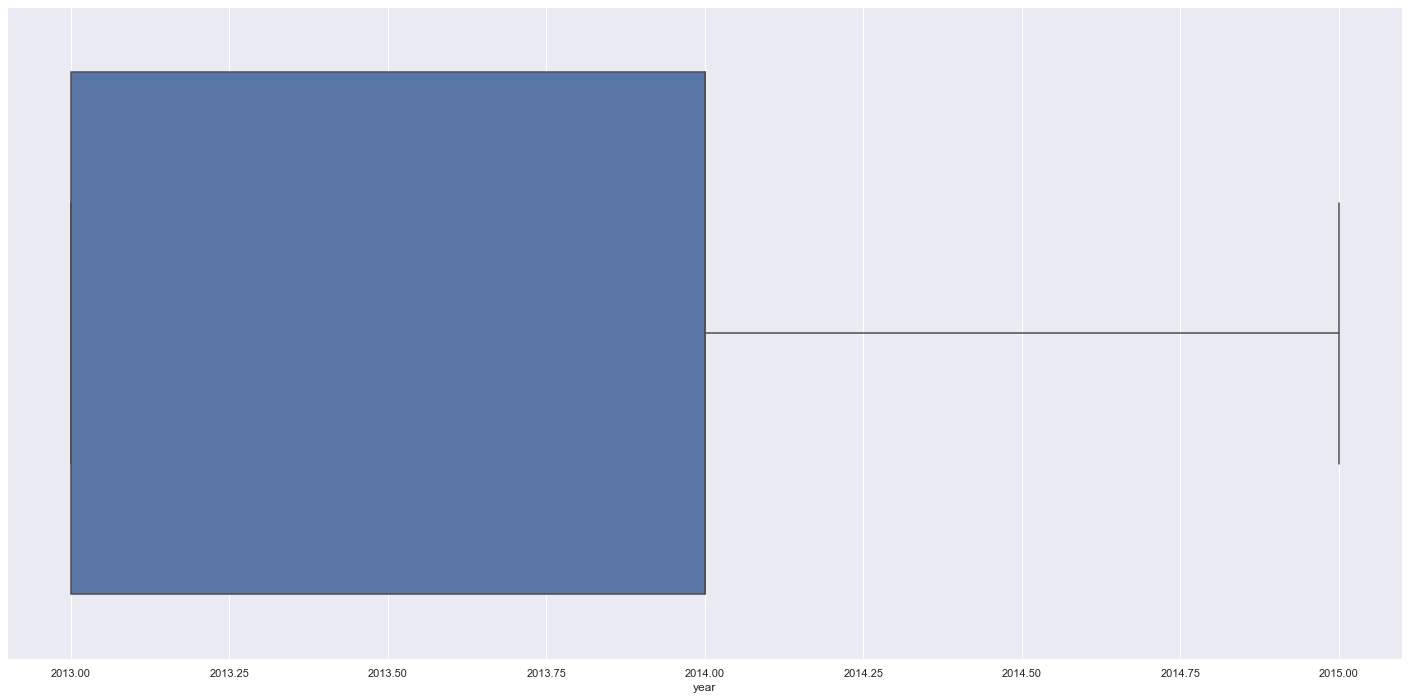

In [179]:
sns.boxplot(df5['year'])

In [180]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Standardization

### 5.3.1 Encoding

In [181]:
# state holiday - One Hot Encodig
df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [182]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1
